## Data 100 Final Project - COVID19 Dataset

Aislin Liu, Anand Chandra

### Imports

In [5]:
import math
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap 
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.base import clone
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

### The Question

What three factors contribute to high numbers per capita of confirmed cases in a county? What can counties focus their energy on scaling up or down to mitigate rapid infection in the event of another widespread pandemic?

# Data

### Data Processing: Abridged Counties

In this cell, we reformat dates, drop fields we don't find important, and add the field `Hospitals Per Capita`

In [6]:
# Import counties data
abridged_counties = pd.read_csv("abridged_couties.csv")

# Convert the Gregorian dates to UTC timestamp
# Columns that need this: "Stay Home UTC", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"
def ordinalToTimeStamp(series):
    arr = []
    array_form = series.values
    for o_date in array_form:
        if not math.isnan(o_date):
            timestamp = pd.Timestamp.fromordinal(int(o_date)).timestamp()
            arr.append(timestamp)
        else:
            arr.append(0)
    return arr
gregorian = ["stay at home", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"]
for column in gregorian:
    abridged_counties[column] = ordinalToTimeStamp(abridged_counties[column])
    
# Drop columns
abridged_counties = abridged_counties.drop(["lat", "lon", "POP_LATITUDE", "POP_LONGITUDE", "CensusRegionName", "CensusDivisionName"], axis=1)

# Hospitals Per Capita
abridged_counties["Hospitals Per Capita"] = abridged_counties["#Hospitals"] / abridged_counties["PopulationEstimate2018"]
abridged_counties = abridged_counties.rename(columns={'stay at home': 'Stay Home UTC'})
abridged_counties.head(10)

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,...,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,Hospitals Per Capita
0,01001,1.0,1.0,Autauga,AL,Alabama,2.0,55601.0,27007.0,28497.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.4354,NaN,NaN,NaN,0.000018
1,01003,1.0,3.0,Baldwin,AL,Alabama,3.0,218022.0,103225.0,109403.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.2162,NaN,NaN,NaN,0.000014
2,01005,1.0,5.0,Barbour,AL,Alabama,6.0,24881.0,13335.0,11935.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.9959,6.08,5400.0,18241.0,0.000040
3,01007,1.0,7.0,Bibb,AL,Alabama,1.0,22400.0,12138.0,10530.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.6003,2.75,14980.0,6120.0,0.000045
4,01009,1.0,9.0,Blount,AL,Alabama,1.0,57840.0,28607.0,29406.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.4242,7.21,31850.0,25233.0,0.000017
5,01011,1.0,11.0,Bullock,AL,Alabama,6.0,10138.0,5615.0,4694.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.8898,2.38,3000.0,7153.0,0.000099
6,01013,1.0,13.0,Butler,AL,Alabama,6.0,19680.0,9232.0,10593.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.8653,1.31,16290.0,3918.0,0.000051
7,01015,1.0,15.0,Calhoun,AL,Alabama,3.0,114277.0,55149.0,59579.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.8252,4.24,35160.0,12712.0,0.000018
8,01017,1.0,17.0,Chambers,AL,Alabama,6.0,33615.0,16140.0,17573.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.7382,NaN,NaN,NaN,0.000000
9,01019,1.0,19.0,Cherokee,AL,Alabama,6.0,26032.0,12846.0,13011.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.4516,2.75,15855.0,9610.0,0.000038


### Data Processing: Confirmed

We address null values. In the "Admin2" column, nulls were replaced with empty string for when the data point had no county name stored. All areas/regions that had NaN for "FIPS" column is because they were not an actual county but still a group of people with noteworthy virus infection like correctional facilities. No actual US county has a FIPS of 0 so we filled these nulls in with 0. 

In [7]:
confirmed = pd.read_csv("time_series_covid19_confirmed_US.csv")
print("There are currently " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")
confirmed["Admin2"].fillna("", inplace=True)
confirmed["FIPS"].fillna(0, inplace=True)
print("There are now " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")

There are currently 11 NaN values in confirmed
There are now 0 NaN values in confirmed


### New Dataframe: Thresholds

We create a new dataframe that, for each county, contains all features and our y-value: the peak proportion of confirmed cases

In [103]:
# Add some features
population_estimates = abridged_counties[["Stay Home UTC", "Smokers_Percentage", 'MedianAge2010', 'countyFIPS', '#Hospitals', 'PopulationEstimate2018', 'RespMortalityRate2014', 'dem_to_rep_ratio', "SVIPercentile", "Hospitals Per Capita"]]

# Drop others
confirmed_modified = confirmed.drop(['iso2', 'iso3', 'code3', 'FIPS', 'Province_State', 'Country_Region', 'Combined_Key', 'Lat', 'Long_'], axis='columns')
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != '']
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != 'Unassigned']

# Find max percentage
find_max = confirmed_modified.drop(['Admin2'], axis='columns')
find_max = find_max.set_index('UID')
max_vals = find_max.max(axis=1).to_frame()
confirmed_for_thresholds = confirmed[['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Combined_Key']].rename(columns={'FIPS': 'countyFIPS'})
confirmed_for_thresholds['countyFIPS'] = confirmed_for_thresholds['countyFIPS'].astype('int64').astype('str')

# Add field: First confirmed case timestamp
all_date_strings = list(confirmed_modified.drop(['UID', 'Admin2'], axis='columns').columns)
def findFirstTimestamp(data):
    for date_string in all_date_strings:
        if data[date_string] > 0:
            return (datetime.strptime(date_string, '%m/%d/%y').timestamp() / 1000000 - 1500) # recenter
confirmed_modified['First Confirmed Case UTC'] = confirmed_modified.apply(lambda data: findFirstTimestamp(data), axis=1)
timestamps = confirmed_modified[['UID', 'First Confirmed Case UTC']]
timestamps = timestamps.set_index('UID')

# Create thresholds
thresholds = confirmed_for_thresholds.merge(population_estimates, on='countyFIPS').dropna()
thresholds = thresholds.merge(max_vals, on='UID')
thresholds = thresholds.rename(columns={0: 'Max_Confirmed'})
thresholds['Max_Percent_Confirmed'] = thresholds['Max_Confirmed'] / thresholds['PopulationEstimate2018']
thresholds = thresholds[thresholds["Max_Percent_Confirmed"] != 0]
thresholds = thresholds.merge(timestamps, on='UID')
thresholds['Stay Home UTC'] = (thresholds['Stay Home UTC'] / 1000000) - 1500
thresholds['Stay Home Confirmed Diff'] = thresholds['Stay Home UTC'] - thresholds['First Confirmed Case UTC']
print(thresholds.shape)
thresholds.head(10)

(2450, 22)


,UID,iso2,iso3,code3,countyFIPS,Admin2,Province_State,Country_Region,Combined_Key,Stay Home UTC,...,#Hospitals,PopulationEstimate2018,RespMortalityRate2014,dem_to_rep_ratio,SVIPercentile,Hospitals Per Capita,Max_Confirmed,Max_Percent_Confirmed,First Confirmed Case UTC,Stay Home Confirmed Diff
0,84010001,US,USA,840,10001,Kent,Delaware,US,"Kent, Delaware, US",85.0080,...,1.0,178550.0,62.05,0.901598,0.7268,0.000006,417,0.002335,84.5148,0.4932
1,84010003,US,USA,840,10003,New Castle,Delaware,US,"New Castle, Delaware, US",85.0080,...,2.0,559335.0,49.38,1.904928,0.3761,0.000004,1205,0.002154,83.9100,1.0980
2,84010005,US,USA,840,10005,Sussex,Delaware,US,"Sussex, Delaware, US",85.0080,...,3.0,229286.0,50.21,0.628212,0.4019,0.000013,886,0.003864,84.4284,0.5796
3,84011001,US,USA,840,11001,District of Columbia,District of Columbia,US,"District of Columbia,District of Columbia,US",85.6992,...,6.0,702455.0,30.21,22.229820,0.5965,0.000009,2666,0.003795,84.3420,1.3572
4,84012001,US,USA,840,12001,Alachua,Florida,US,"Alachua, Florida, US",85.0944,...,2.0,269956.0,52.85,1.618909,0.4729,0.000007,215,0.000796,83.9100,1.1844
5,84012003,US,USA,840,12003,Baker,Florida,US,"Baker, Florida, US",85.8720,...,1.0,28355.0,97.07,0.205168,0.6803,0.000035,17,0.000600,84.7740,1.0980
6,84012005,US,USA,840,12005,Bay,Florida,US,"Bay, Florida, US",85.8720,...,2.0,185287.0,79.48,0.350468,0.6076,0.000011,48,0.000259,84.7740,1.0980
7,84012007,US,USA,840,12007,Bradford,Florida,US,"Bradford, Florida, US",85.8720,...,1.0,27732.0,76.84,0.328060,0.9264,0.000036,42,0.001514,84.8604,1.0116
8,84012009,US,USA,840,12009,Brevard,Florida,US,"Brevard, Florida, US",85.8720,...,7.0,596849.0,57.16,0.658127,0.3713,0.000012,210,0.000352,84.4284,1.4436
9,84012011,US,USA,840,12011,Broward,Florida,US,"Broward, Florida, US",85.2672,...,14.0,1951260.0,39.77,2.120398,0.5844,0.000007,3838,0.001967,83.5680,1.6992


### Plot Distribution of Peak Confirmed Cases

Text(0.5, 1.0, 'Distribution of the Max Percent of Confirmed Cases')

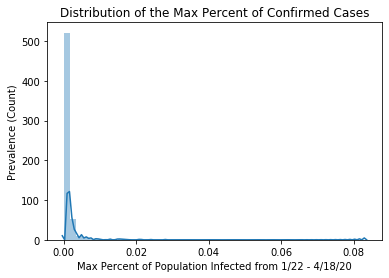

In [9]:
sns.distplot(thresholds["Max_Percent_Confirmed"], norm_hist=False)
plt.ylabel("Prevalence (Count)")
plt.xlabel("Max Percent of Population Infected from 1/22 - 4/18/20")
plt.title("Distribution of the Max Percent of Confirmed Cases")

From this distribution plot of the Max Percent of Population Infected during our time period of interest, 1/22 - 4/18/20, we see a large majority of the values cluster near 0 and are generally very low. This signifies that in calculating error, the values will be numerically low just because of the data values we are working with. We need to evaluate errors from our models while keeping this in mind.

# Feature Selection

### Create Test/Train Sets

In [10]:
train, test = train_test_split(thresholds, test_size=.20, random_state=42)

### Cross Validation Set-Up

This function takes in training data (we will be passing in training data with different features) and calculates the loss

In [11]:
def crossValidateMSE(model, train, y):
    five_fold = KFold(n_splits=5)
    mse_values = []
    for tr_ind, va_ind in five_fold.split(train):
        model.fit(train.iloc[tr_ind, :], y.iloc[tr_ind])
        mse_values.append(mean_squared_error(y.iloc[va_ind], model.predict(train.iloc[va_ind,:])))
    return np.mean(mse_values)

### Import and Visualize Features

We define the features we plan to use, and exclude the ones that we cannot use (for example, UID or county name)

In [12]:
all_features = list(thresholds.columns)
print(all_features)
usable_features = ["Stay Home UTC", "Smokers_Percentage", 'MedianAge2010', 'RespMortalityRate2014', 'dem_to_rep_ratio', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC', 'Stay Home Confirmed Diff']
usable_features

['UID', 'iso2', 'iso3', 'code3', 'countyFIPS', 'Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'Stay Home UTC', 'Smokers_Percentage', 'MedianAge2010', '#Hospitals', 'PopulationEstimate2018', 'RespMortalityRate2014', 'dem_to_rep_ratio', 'SVIPercentile', 'Hospitals Per Capita', 'Max_Confirmed', 'Max_Percent_Confirmed', 'First Confirmed Case UTC', 'Stay Home Confirmed Diff']


['Stay Home UTC',
 'Smokers_Percentage',
 'MedianAge2010',
 'RespMortalityRate2014',
 'dem_to_rep_ratio',
 'SVIPercentile',
 'Hospitals Per Capita',
 'First Confirmed Case UTC',
 'Stay Home Confirmed Diff']

Below we create some visualizations to get a general overview of the relationships between different features and our Y variable, "Max_Percent_Confirmed" from our train dataframe.

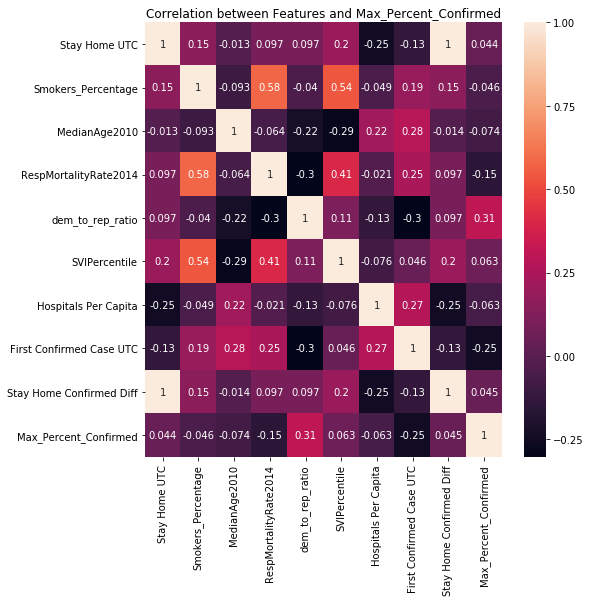

In [13]:
visualization_df = train[usable_features]
visualization_df["Max_Percent_Confirmed"] = train["Max_Percent_Confirmed"]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(visualization_df.corr(), annot=True)
plt.title("Correlation between Features and Max_Percent_Confirmed")
plt.show()

It appears the features `dem_to_rep_ratio` and `First Confirmed Case UTC` both have strong correlations magnitude-wise and could be good potential indicators for `Max_Percent_Confirmed`. The other features have lower correlations directly with `Max_Percent_Confirmed` but have a high correlation with one of the stronger correlation features like `First Confirmed Case UTC`. Below are some scatterplots of different single features versus our Y variable `Max_Percent_Confirmed`. Logarithm transformations were applied where appropriate for better visualizations that preserve relationships of variables.

Text(0, 0.5, 'Log. Max_Percent_Confirmed')

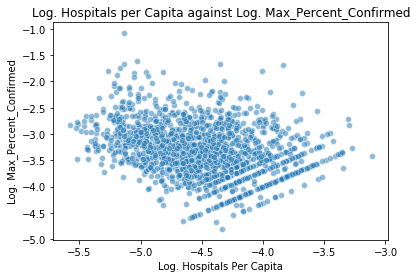

In [70]:
#Scatter plot of some features of interest like Hospitals Per Capita
sns.scatterplot(x=np.log10(train["Hospitals Per Capita"]), y=np.log10(train["Max_Percent_Confirmed"]), alpha=.5)
plt.title("Log. Hospitals per Capita against Log. Max_Percent_Confirmed")
plt.xlabel("Log. Hospitals Per Capita")
plt.ylabel("Log. Max_Percent_Confirmed")

Text(0, 0.5, 'Log. Max_Percent_Confirmed')

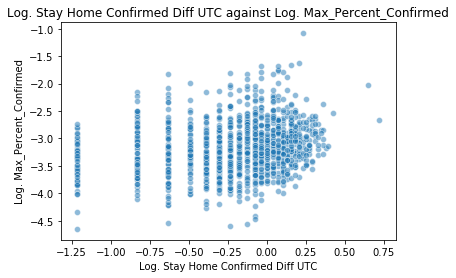

In [72]:
#Scatter plot of Stay Home Confirmed Diff (difference in UTC of stay home orders v. first case) --> measure of response time
sns.scatterplot(x = np.log10(train["Stay Home Confirmed Diff"]), y = np.log10(train["Max_Percent_Confirmed"]), alpha=.5)
plt.title("Log. Stay Home Confirmed Diff UTC against Log. Max_Percent_Confirmed")
plt.xlabel("Log. Stay Home Confirmed Diff UTC")
plt.ylabel("Log. Max_Percent_Confirmed")

### Regression Model Selection

Below we test losses across `LinearRegression` model and `DecisionTreeRegressor` model to choose the optimal one for our dataset. We manually feed in set of combination of features just to ensure consistency across models trained on different training data to ensure our choice in model is not from over-fitting of one instance. 

In [22]:
# Indices of the usable_features
# 0, 1, 2 means we use Stay Home UTC, Smokers_Percentage, MedianAge2010
combinations = [
    [0, 1, 2, 3, 4, 5, 6, 7],
    [0, 1, 2, 3, 4],
    [0, 1, 2],
]

#Save losses for visualization purposes
tree_losses = {}
lin_losses = {}

y = train['Max_Percent_Confirmed']
best_combination = 0
min_loss = math.inf
best_model_is_linear = True
for i in range(len(combinations)):
    print('TESTING COMBINATION: {}'.format(i))
    combination = combinations[i]
    features = [usable_features[j] for j in combination]
    training_data = train[features]
    linear_error = crossValidateMSE(LinearRegression(), training_data, y)
    tree_error = crossValidateMSE(tree.DecisionTreeRegressor(), training_data, y)
    tree_losses[i] = tree_error
    lin_losses[i] = linear_error
    loss = min(linear_error, tree_error)
    print('LINEAR ERROR: {}'.format(linear_error))
    print('TREE ERROR: {}'.format(tree_error))
    print()
    #Saving the loss from using all n features for use in comparisons later
    if i == 0:
        combo_0_loss_cv = loss
    if loss < min_loss:
        min_loss = loss
        best_combination = i
        best_model_is_linear = linear_error < tree_error

print('SUMMARY')
print('BEST COMBINATION: {} WITH LOSS OF {}'.format(best_combination, min_loss))

TESTING COMBINATION: 0
LINEAR ERROR: 6.99198565507561e-06
TREE ERROR: 6.82797843410285e-06

TESTING COMBINATION: 1
LINEAR ERROR: 7.292744269947609e-06
TREE ERROR: 8.727968894164331e-06

TESTING COMBINATION: 2
LINEAR ERROR: 6.928082653512627e-06
TREE ERROR: 8.97022416651415e-06

SUMMARY
BEST COMBINATION: 0 WITH LOSS OF 6.82797843410285e-06


In [23]:
#Function that takes in 2 dictionaries of losses --> loss1, loss2 and names to label plot
def compareModels(loss1, name1, loss2, name2):
    names = list(loss1.keys())
    fig = go.Figure([
        go.Bar(x = names, y = list(loss1.values()), name=name1), 
        go.Bar(x = names, y = list(loss2.values()), name=name2)])
    return fig

fig = compareModels(tree_losses, "dTree CV MSE", lin_losses, "LinReg CV MSE")
fig.update_layout(
    title="Comparison of CV MSE of DecisionTreeRegressor and LinearRegression Models",
    xaxis_title="Feature Combo",
    yaxis_title="CV MSE")
fig.show()

From the visualizaiton above, we see that across different combinations of features we see lower cross-validation error for `LinearRegression` model compared to `DecisionTreeRegressor` model so we proceed to explore optimal feature selection for our `LinearRegression` model.

### Testing Different Feature Combinations

In the cells below we manually sample a combination of (n - 1) features where n = number of usable features we have. We compare their cross validation MSE against cross validation MSE of a model with features used to see which features are more valuable than others.

In [20]:
#dictionaries being filled with key = feature left out, value = resulting mse on this model 
def leastUsefulFeature(usable_features):
    losses_cv = {}
    for feature in usable_features:
        copy = usable_features.copy()
        copy.remove(feature)
        training_data = train[copy]
        cv_linear_error = crossValidateMSE(LinearRegression(), training_data, y)
        losses_cv[feature] = cv_linear_error
    return losses_cv

#Save best CV Loss with one feature missing
losses_cv = leastUsefulFeature(usable_features)
best_loss = (min(losses_cv, key=losses_cv.get), min(list(losses_cv.values())))
print('BEST COMBINATION: LEAVING OUT {} WITH LOSS OF {}'.format(best_loss[0], best_loss[1]))

BEST COMBINATION: LEAVING OUT dem_to_rep_ratio WITH LOSS OF 6.461769065430571e-06


In [24]:
#losses is a dictionary where keys = features of the model, value = mean squared error of the model
all_loss = {}
for feature in usable_features:
    all_loss[feature] = combo_0_loss_cv
    
fig = compareModels(losses_cv, "Left Out Feature", all_loss, "All Features")
fig.update_layout(
    title="Comparison of CV MSE After Leaving Out Single Features",
    xaxis_title="Feature Left Out",
    yaxis_title="CV MSE")
fig.show()

From the visualization above, we can see that certain features are more valuable to the linear regression model than others. It appears that `First Confirmed Case UTC` is valuable to predicting the `Max Percent Confirmed` Cases since error increased when it was left out which makes sense since later first infection dates will have slower growth and have a lower proportion of the infected. Leaving out `dem_to_rep_ratio` seems to do the most in reducing model error which makes sense since compared to the other features, this one is the least health related though we were curious of the higher proportion of Republicans protesting stay-at-home orders influenced confirmed cases. We proceed by removing `dem_to_rep_ratio` from possible features.

Repeating the process above to visualize and compare all possible combinations of n features would be tedious and inefficient. I found a sklearn tool called `Recursive Feature Elimination` that efficiently takes the number of features you wish to have and recursively selects the best feature for the model until the number of features selected equals the number we indicated we wanted. Since we hope to provide recommendations on the top 3 factors a county should devote resources towards improving to mitigate infection rates in the event of future pandemics this was an optimal tool for us.

### Selecting Top 3 Features

In [37]:
from sklearn.feature_selection import RFE

# Prevent mutations to usable_features
copy = usable_features.copy()
copy.remove("dem_to_rep_ratio")
print("Possible Features: ")
print(copy)
print()

# Initialize training_data and model
training_data = train[copy]
model = LinearRegression()


# Selecting RFE for combos of n = 3 features
rfe = RFE(model, 3)
fit = rfe.fit(training_data, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: ")
feats = []
for j in range(len(copy)):
    if fit.ranking_[j] == 1:
        feats.append(copy[j])
print(feats)

Possible Features: 
['Stay Home UTC', 'Smokers_Percentage', 'MedianAge2010', 'RespMortalityRate2014', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC', 'Stay Home Confirmed Diff']

Num Features: 3
Selected Features: 
['SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC']


The cell above determines using `Recursive Feature Elimination` that the top three features that most influence Max_Percent_Confirmed cases in a county are SVI Percentile, Hospitals Per Capita, and First Confirmed Case. We explore strengths of relationships of these features with our Y variable in the below scatterplots.

### Visualizations

Text(0, 0.5, 'LOG Max_Percent_Confirmed')

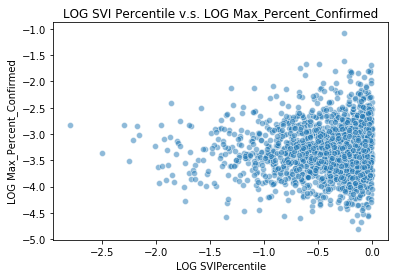

In [95]:
sns.scatterplot(x=np.log10(train["SVIPercentile"]), y=np.log10(train["Max_Percent_Confirmed"]), alpha=.5)
plt.title("LOG SVI Percentile v.s. LOG Max_Percent_Confirmed")
plt.xlabel("LOG SVIPercentile")
plt.ylabel("LOG Max_Percent_Confirmed")

Text(0, 0.5, 'LOG Max_Percent_Confirmed')

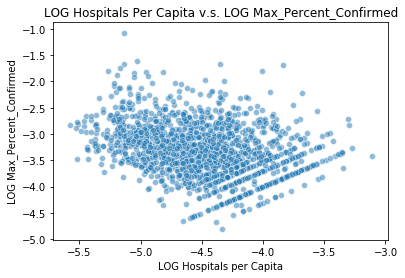

In [97]:
#Was plotted above in feature exploration but wanted to compare with other strong influence features here
sns.scatterplot(x=np.log10(train["Hospitals Per Capita"]), y=np.log10(train["Max_Percent_Confirmed"]), alpha=.5)
plt.title("LOG Hospitals Per Capita v.s. LOG Max_Percent_Confirmed")
plt.xlabel("LOG Hospitals per Capita")
plt.ylabel("LOG Max_Percent_Confirmed")

Text(0, 0.5, 'LOG Max_Percent_Confirmed')

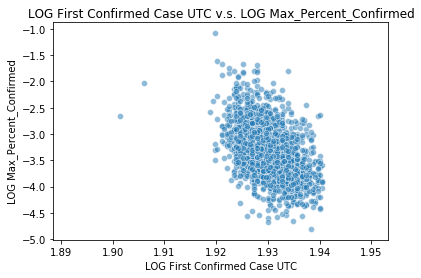

In [99]:
sns.scatterplot(x=np.log10(train["First Confirmed Case UTC"]), y=np.log10(train["Max_Percent_Confirmed"]), alpha=.5)
plt.title("LOG First Confirmed Case UTC v.s. LOG Max_Percent_Confirmed")
plt.xlabel("LOG First Confirmed Case UTC")
plt.ylabel("LOG Max_Percent_Confirmed")

From these scatterplots of our identified top three factors, we see a stronger relationship between Hospitals Per Capita and Max_Percent_Confirmed. SVI Percentile and Max_Percent_Confirmed don't appear to have too strong of a relationship in the plot. First Confirmed Case UTC has the most outliers in its plot which makes sense given slow spread with first sight of a patient zero. The relationship between First Confirmed Case UTC and Max_Percent_Confirmed is hard to decipher with the cluster given but it appears there is still a relationship (that appears to be of negative slope).

# Conclusions

Our RFE suggests that the top features in predicting higher proportions of cases are the date of the first confirmed case and the date of the stay home order, the SVI Percentile, and the number of hospitals per capita. 

From these conclusions, we'd advise counties to mandate stay home orders as soon as possible, and in counties that have fewer hospitals per capita and higher SVI percentiles, to strictly enforce these orders. For preparation for the possibility of future pandemics or even flu season (to a lesser extent), counties should devote budget to properly ensuring hospitals are properly scaled to growing populations and to work towards improving the socioeconomic levels within the county.


# Other Things We Tried

### Feature Selection and Model Building

Another direction we were previously planning to explore was fitting a model with a combination of features that would lead to the best predictions on max per capita infection proportion in a county in the time period before 4/18/20. Below we continue with selection of a feature combo. We previously were hoping that creating an accurate model for predicting max per capita infection in a county prior to 4/18/20 could be scaled and used to predict eventual max per capita infection. We realized that predicting for the future could not be done accurately with our current knowledge as we would need disease reproduction rate information for that. 

In [38]:
best_combos = {}

#Iteration through all possible combos 
i = 1
while i < len(copy):
    rfe = RFE(model, i)
    fit = rfe.fit(training_data, y)
    print("Num Features: %d" % fit.n_features_)
    print("Selected Features: ")
    feats = []
    for j in range(len(copy)):
        if fit.ranking_[j] == 1:
            feats.append(copy[j])
    best_combos[i] = feats
    print(feats)
    i += 1

#Calculating loss for the optimal feature combo for each number of features
losses = {}
for combo in best_combos.keys():
    feats = best_combos[combo]
    training_data = train[feats]
    cv_linear_error = crossValidateMSE(LinearRegression(), training_data, y)
    losses[combo] = cv_linear_error

#Plot comparison
fig = compareModels(losses, "CV MSE", {}, "")
fig.add_trace(go.Scatter(
    x=list(best_combos.keys()),
    y=[best_loss[1] for _ in list(losses.keys())],
    name="Best CV MSE from Manual Combo Selection"
))
fig.update_layout(
    title="Comparison of CV MSE Over All Best Feature Combos Found From RFE",
    xaxis_title="Best Feature Combination for n Features",
    yaxis_title="CV MSE")
fig.show()

Num Features: 1
Selected Features: 
['Hospitals Per Capita']
Num Features: 2
Selected Features: 
['Hospitals Per Capita', 'First Confirmed Case UTC']
Num Features: 3
Selected Features: 
['SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC']
Num Features: 4
Selected Features: 
['SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC', 'Stay Home Confirmed Diff']
Num Features: 5
Selected Features: 
['Stay Home UTC', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC', 'Stay Home Confirmed Diff']
Num Features: 6
Selected Features: 
['Stay Home UTC', 'RespMortalityRate2014', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC', 'Stay Home Confirmed Diff']
Num Features: 7
Selected Features: 
['Stay Home UTC', 'Smokers_Percentage', 'RespMortalityRate2014', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC', 'Stay Home Confirmed Diff']
{1: 6.952694334233405e-06, 2: 6.598488084764509e-06, 3: 6.559119919038859e-06, 4: 6.5

Above are the results of running sklearn's Recursive Feature Elimination tool, with the number of features we want to fit our model to and the combination of highest-ranked features that would produce the "best-fit" model. The plot shows the cross validation MSE for each of the best combinations for 1 to (n - 1) features and compares to the best error we got from manually sampling (n - 1) features from the total n features we have to see which performed better. RFE and manual sampling returned different a different set of (n - 1) features so we graph the MSE between the two methods to cross-check.

In [94]:
#Select 6 features since 7 doesn't perform much better and may be overfitting
best_features = best_combos[6]
print("THE FEATURES FOR OUR MODEL ARE: ", best_features)

#Initialize and fit LinearRegression model on our features
model = LinearRegression()
model.fit(train[best_features], train["Max_Percent_Confirmed"])
y_hat = model.predict(test[best_features])
error = mean_squared_error(y_hat, test["Max_Percent_Confirmed"])

print()
print("TESTING MSE FOR FINAL MODEL:", error)

THE FEATURES FOR OUR MODEL ARE:  ['Stay Home UTC', 'RespMortalityRate2014', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC', 'Stay Home Confirmed Diff']

TESTING MSE FOR FINAL MODEL: 3.971251734738921e-06


It appears our model on the selected 6 features Stay Home UTC, RespMortalityRate2014, SVIPercentile, Hospitals Per Capita, First Confirmed Case UTC, and Stay Home Confirmed Diff has low testing loss, even lower than the cross-validation loss from the training set on the same features. The model performs well but we did not continue use of it to answer our proposed question.